In [0]:
# print('Continue?(1=YES/0=NO)')
# continue_training=bool(int(input()))
continue_training=False

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

from google.colab import drive
drive.mount('/gdrive')
path = "/gdrive/My Drive/GAN/"
folder = "PGGAN/PGGAN_test3"

!pip install -q tensorflow-gpu==2.0.0-beta1
# import logging
# logging.getLogger('tensorflow').disabled = True
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import random
import time
import shutil, os, sys
from collections import deque
from tensorflow.keras import layers, initializers

from IPython import display
from tqdm import tqdm

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
imgs = []
files = os.listdir(path+"pokemon/")
random.shuffle(files)
file_range = 10 if len(files)-1 > 4000 else len(files)-1
for i in tqdm(range(0, file_range)):
    img = mpimg.imread(path+"pokemon/"+str(files[i]))
    imgs.append(img)

    
def resize(images, size):
    i_list = []
    for i in images:
        i = cv2.resize(i, (size, size), interpolation = cv2.INTER_AREA)
        i_list.append(i)

    train_images = np.array(i_list).astype('float32')
    train_images = train_images/255
    train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
    return train_dataset


def generate_and_save_images(images, layer, epoch):
    fig = plt.figure(figsize=(7,7))
    plt.clf()

    for i in range(images.shape[0]):
        plt.subplot(7, 7, i+1)
        plt.imshow(images[i])
        plt.axis('off')

    plt.savefig(path+folder+'_imgs/image_{:01d}x{:01d}_{:04d}.png'.format(layer, layer, epoch))
    display.clear_output(wait=True)
    print(images.shape)
    plt.show()
    
    
def plot_graph_disc_and_gan(discriminate_loss_list, generate_loss_list, layer):
    plt.clf()
    plt.plot(generate_loss_list, c='g')
    plt.plot(discriminate_loss_list, c='r')
    plt.savefig(path+folder+'_graphs/image_{:01d}x{:01d}.png'.format(layer, layer))
    plt.show()
    
def Equalized_Learning_Rate(w):
    fan_in = tf.reduce_prod(w.shape[:3])
    c = tf.dtypes.cast(tf.sqrt(2/fan_in), tf.float32)
    w = w * c
    return w

100%|██████████| 868/868 [00:19<00:00, 45.88it/s]


In [0]:
class VAE_model(tf.keras.Model):
    def __init__(self):
        super(VAE_model, self).__init__()
        self.pool = layers.AveragePooling2D(strides=2, padding='same')
        self.dropout = layers.Dropout(0.3)
        
        self.layer_256 = layers.Conv2D(16, kernel_size=3, strides=2, activation=layers.LeakyReLU(0.2), padding='same', name='VAE_256', kernel_initializer=initializers.he_normal())#, kernel_constraint=self.Equalized_Learning_Rate())
        self.layer_128 = layers.Conv2D(16, kernel_size=3, strides=2, activation=layers.LeakyReLU(0.2), padding='same', name='VAE_128', kernel_initializer=initializers.he_normal())#, kernel_constraint=self.Equalized_Learning_Rate())
        self.layer_64 = layers.Conv2D(16, kernel_size=3, strides=2, activation=layers.LeakyReLU(0.2), padding='same', name='VAE_64', kernel_initializer=initializers.he_normal())#, kernel_constraint=self.Equalized_Learning_Rate())
        self.layer_32 = layers.Conv2D(32, kernel_size=3, strides=2, activation=layers.LeakyReLU(0.2), padding='same', name='VAE_32', kernel_initializer=initializers.he_normal())#, kernel_constraint=self.Equalized_Learning_Rate())
        self.layer_16 = layers.Conv2D(64, kernel_size=3, strides=2, activation=layers.LeakyReLU(0.2), padding='same', name='VAE_16', kernel_initializer=initializers.he_normal())#, kernel_constraint=self.Equalized_Learning_Rate())
        self.layer_8 = layers.Conv2D(128, kernel_size=3, strides=2, activation=layers.LeakyReLU(0.2), padding='same', name='VAE_8', kernel_initializer=initializers.he_normal())#, kernel_constraint=self.Equalized_Learning_Rate())
        self.flatten = layers.Flatten()
        self.layer_out = layers.Dense(200, name='VAE_dense')
        
        self.layer_256_fromRGB = layers.Conv2D(16, kernel_size=1, strides=1, activation=layers.LeakyReLU(0.2), padding='same', name='VAE_256_fromRGB', kernel_initializer=initializers.he_normal())
        self.layer_128_fromRGB = layers.Conv2D(16, kernel_size=1, strides=1, activation=layers.LeakyReLU(0.2), padding='same', name='VAE_128_fromRGB', kernel_initializer=initializers.he_normal())
        self.layer_64_fromRGB = layers.Conv2D(16, kernel_size=1, strides=1, activation=layers.LeakyReLU(0.2), padding='same', name='VAE_64_fromRGB', kernel_initializer=initializers.he_normal())
        self.layer_32_fromRGB = layers.Conv2D(16, kernel_size=1, strides=1, activation=layers.LeakyReLU(0.2), padding='same', name='VAE_32_fromRGB', kernel_initializer=initializers.he_normal())
        self.layer_16_fromRGB = layers.Conv2D(32, kernel_size=1, strides=1, activation=layers.LeakyReLU(0.2), padding='same', name='VAE_16_fromRGB', kernel_initializer=initializers.he_normal())
        self.layer_8_fromRGB = layers.Conv2D(64, kernel_size=1, strides=1, activation=layers.LeakyReLU(0.2), padding='same', name='VAE_8_fromRGB', kernel_initializer=initializers.he_normal())
        self.layer_4_fromRGB = layers.Conv2D(128, kernel_size=1, strides=1, activation=layers.LeakyReLU(0.2), padding='same', name='VAE_4_fromRGB', kernel_initializer=initializers.he_normal())
        
        self.fader = tf.Variable(1, name='fader', dtype=tf.float32, trainable=False)
        self.vae_loss_var = tf.Variable(0.01, dtype=tf.float32)
        
        
    class Equalized_Learning_Rate(tf.keras.constraints.Constraint):
        def __call__(self, w):
            fan_in = tf.reduce_prod(w.shape[:3])
            c = tf.dtypes.cast(tf.sqrt(2/fan_in), tf.float32)
            return w * c
        
        
    @tf.function
    def model(self, inputs):
        if inputs.shape[1] == 4:
            outputs = self.model_4(inputs)
        elif inputs.shape[1] == 8:
            outputs = self.model_8(inputs)
        elif inputs.shape[1] == 16:
            outputs = self.model_16(inputs)
        elif inputs.shape[1] == 32:
            outputs = self.model_32(inputs)
        elif inputs.shape[1] == 64:
            outputs = self.model_64(inputs)
        elif inputs.shape[1] == 128:
            outputs = self.model_128(inputs)
        else:
            outputs = self.model_256(inputs)
        return outputs
        
        
        
    @tf.function
    def model_256(self, inputs):
        x = self.layer_256_fromRGB(inputs)
        x = self.layer_256(x)
        
        old = self.pool(inputs)
        old = self.layer_128_fromRGB(old)
        x = (x * self.fader) + (old * (1-self.fader))
        
        return self.model_128_main(x)
        
    @tf.function
    def model_128(self, inputs):
        x = self.layer_128_fromRGB(inputs)
        x = self.layer_128(x)
        
        old = self.pool(inputs)
        old = self.layer_64_fromRGB(old)
        x = (x * self.fader) + (old * (1-self.fader))
        
        return self.model_64_main(x)
        
    @tf.function
    def model_64(self, inputs):
        x = self.layer_64_fromRGB(inputs)
        x = self.layer_64(x)
        
        old = self.pool(inputs)
        old = self.layer_32_fromRGB(old)
        x = (x * self.fader) + (old * (1-self.fader))

        return self.model_32_main(x)
     
    @tf.function   
    def model_32(self, inputs):
        x = self.layer_32_fromRGB(inputs)
        x = self.layer_32(x)
        
        old = self.pool(inputs)
        old = self.layer_16_fromRGB(old)
        x = (x * self.fader) + (old * (1-self.fader))

        return self.model_16_main(x)
       
    @tf.function 
    def model_16(self, inputs):
        x = self.layer_16_fromRGB(inputs)
        x = self.layer_16(x)
        
        old = self.pool(inputs)
        old = self.layer_8_fromRGB(old)
        x = (x * self.fader) + (old * (1-self.fader))
        
        return self.model_8_main(x)

    @tf.function   
    def model_8(self, inputs):
        x = self.layer_8_fromRGB(inputs)
        x = self.layer_8(x)
        
        old = self.pool(inputs)
        old = self.layer_4_fromRGB(old)
        x = (x * self.fader) + (old * (1-self.fader))
        
        return self.model_4_main(x)
        
    @tf.function
    def model_4(self, inputs):
        x = self.layer_4_fromRGB(inputs)
        return self.model_4_main(x)
    
    
        
    @tf.function
    def model_128_main(self, inputs):
        x = self.layer_128(inputs)
        return self.model_64_main(x)
        
    @tf.function
    def model_64_main(self, inputs):
        x = self.layer_64(inputs)
        return self.model_32_main(x)
        
    @tf.function
    def model_32_main(self, inputs):
        x = self.layer_32(inputs)
        return self.model_16_main(x)
        
    @tf.function
    def model_16_main(self, inputs):
        x = self.layer_16(inputs)
        return self.model_8_main(x)
        
    @tf.function
    def model_8_main(self, inputs):
        x = self.layer_8(inputs)
        return self.model_4_main(x)
    
    @tf.function
    def model_4_main(self, inputs):
        x = self.layer_out(self.flatten(inputs))
        
        mean, logvar = tf.split(x, num_or_size_splits=2, axis=1)
        eps = tf.random.normal(shape=mean.shape)
        x = eps * tf.exp(logvar * .5) + mean
        
        return x, mean, logvar
    
    
    
    
    
vae = VAE_model()

In [0]:
class GEN_model(tf.keras.Model):
    def __init__(self):
        super(GEN_model, self).__init__()
        self.relu = layers.LeakyReLU(0.2)
        self.layer_upsample = layers.UpSampling2D()
        
        self.layer_dense = layers.Dense(4*4*256, activation=layers.LeakyReLU(0.2), name='GEN_dense')
        self.reshape_4 = layers.Reshape((4, 4, 256))
        self.layer_8 = layers.Conv2D(128, kernel_size=3, strides=1, activation=self.pixelwise_feat_norm, use_bias=False, padding='same', name='GEN_8', kernel_initializer=initializers.he_normal())#, kernel_constraint=self.Equalized_Learning_Rate())
        self.layer_16 = layers.Conv2D(64, kernel_size=3, strides=1, activation=self.pixelwise_feat_norm, use_bias=False, padding='same', name='GEN_16', kernel_initializer=initializers.he_normal())#, kernel_constraint=self.Equalized_Learning_Rate())
        self.layer_32 = layers.Conv2D(32, kernel_size=3, strides=1, activation=self.pixelwise_feat_norm, use_bias=False, padding='same', name='GEN_32', kernel_initializer=initializers.he_normal())#, kernel_constraint=self.Equalized_Learning_Rate())
        self.layer_64 = layers.Conv2D(16, kernel_size=3, strides=1, activation=self.pixelwise_feat_norm, use_bias=False, padding='same', name='GEN_64', kernel_initializer=initializers.he_normal())#, kernel_constraint=self.Equalized_Learning_Rate())
        self.layer_128 = layers.Conv2D(16, kernel_size=3, strides=1, activation=self.pixelwise_feat_norm, use_bias=False, padding='same', name='GEN_128', kernel_initializer=initializers.he_normal())#, kernel_constraint=self.Equalized_Learning_Rate())
        self.layer_256 = layers.Conv2D(16, kernel_size=3, strides=1, activation=self.pixelwise_feat_norm, use_bias=False, padding='same', name='GEN_256', kernel_initializer=initializers.he_normal())#, kernel_constraint=self.Equalized_Learning_Rate())
        
        self.layer_4_toRGB = layers.Conv2D(3, kernel_size=1, strides=1, use_bias=False, padding='same', name='GEN_4_toRGB', kernel_initializer=initializers.he_normal())
        self.layer_8_toRGB = layers.Conv2D(3, kernel_size=1, strides=1, use_bias=False, padding='same', name='GEN_8_toRGB', kernel_initializer=initializers.he_normal())
        self.layer_16_toRGB = layers.Conv2D(3, kernel_size=1, strides=1, use_bias=False, padding='same', name='GEN_16_toRGB', kernel_initializer=initializers.he_normal())
        self.layer_32_toRGB = layers.Conv2D(3, kernel_size=1, strides=1, use_bias=False, padding='same', name='GEN_32_toRGB', kernel_initializer=initializers.he_normal())
        self.layer_64_toRGB = layers.Conv2D(3, kernel_size=1, strides=1, use_bias=False, padding='same', name='GEN_64_toRGB', kernel_initializer=initializers.he_normal())
        self.layer_128_toRGB = layers.Conv2D(3, kernel_size=1, strides=1, use_bias=False, padding='same', name='GEN_128_toRGB', kernel_initializer=initializers.he_normal())
        self.layer_256_toRGB = layers.Conv2D(3, kernel_size=1, strides=1, use_bias=False, padding='same', name='GEN_256_toRGB', kernel_initializer=initializers.he_normal())
        
        self.fader = tf.Variable(1, name='fader', dtype=tf.float32, trainable=False)
        
        

    class Equalized_Learning_Rate(tf.keras.constraints.Constraint):
        def __call__(self, w):
            fan_in = tf.reduce_prod(w.shape[:3])
            c = tf.dtypes.cast(tf.sqrt(2/fan_in), tf.float32)
            w = w * c
            return w
        
    @tf.function
    def pixelwise_feat_norm(self, outputs):
        outputs = self.relu(outputs)
        normalization_constant = tf.sqrt(tf.reduce_mean(outputs**2, axis=-1, keepdims=True) + 1.0e-8)
        outputs / normalization_constant
        return outputs

        
    @tf.function
    def model(self, inputs, shape=256):
        if shape == 4:
            outputs = self.model_4(inputs)
        elif shape == 8:
            outputs = self.model_8(inputs)
        elif shape == 16:
            outputs = self.model_16(inputs)
        elif shape == 32:
            outputs = self.model_32(inputs)
        elif shape == 64:
            outputs = self.model_64(inputs)
        elif shape == 128:
            outputs = self.model_128(inputs)
        else:
            outputs = self.model_256(inputs)
        return outputs
        
        
    @tf.function
    def model_4(self, inputs):
        x = self.model_4_main(inputs)
        x = self.layer_4_toRGB(x)
        return x

    @tf.function
    def model_8(self, inputs):
        main = self.model_4_main(inputs)
        x = self.layer_upsample(main)
        x = self.layer_8(x)
        x = self.layer_8_toRGB(x)
        
        old = self.layer_4_toRGB(main)
        old = self.layer_upsample(old)
        x = (x * self.fader) + (old * (1-self.fader))
        
        return x
        
    @tf.function
    def model_16(self, inputs):
        main = self.model_8_main(inputs)
        x = self.layer_upsample(main)
        x = self.layer_16(x)
        x = self.layer_16_toRGB(x)
        
        old = self.layer_8_toRGB(main)
        old = self.layer_upsample(old)
        x = (x * self.fader) + (old * (1-self.fader))
        
        return x
    
    
    @tf.function
    def model_32(self, inputs):
        main = self.model_16_main(inputs)
        x = self.layer_upsample(main)
        x = self.layer_32(x)
        x = self.layer_32_toRGB(x)
        
        old = self.layer_16_toRGB(main)
        old = self.layer_upsample(old)
        x = (x * self.fader) + (old * (1-self.fader))
        
        return x
        
    @tf.function
    def model_64(self, inputs):
        main = self.model_32_main(inputs)
        x = self.layer_upsample(main)
        x = self.layer_64(x)
        x = self.layer_64_toRGB(x)
        
        old = self.layer_32_toRGB(main)
        old = self.layer_upsample(old)
        x = (x * self.fader) + (old * (1-self.fader))
        
        return x
        
    @tf.function
    def model_128(self, inputs):
        main = self.model_64_main(inputs)
        x = self.layer_upsample(main)
        x = self.layer_128(x)
        x = self.layer_128_toRGB(x)
        
        old = self.layer_64_toRGB(main)
        old = self.layer_upsample(old)
        x = (x * self.fader) + (old * (1-self.fader))
        
        return x
       
    @tf.function 
    def model_256(self, inputs):
        main = self.model_128_main(inputs)
        x = self.layer_upsample(main)
        x = self.layer_256(x)
        x = self.layer_256_toRGB(x)
        
        old = self.layer_128_toRGB(main)
        old = self.layer_upsample(old)
        x = (x * self.fader) + (old * (1-self.fader))
        
        return x
    
    
    
    
    @tf.function
    def model_4_main(self, inputs):
        x = self.layer_dense(inputs)
        x = self.reshape_4(x)
        return x     
        
    @tf.function
    def model_8_main(self, inputs):
        x = self.model_4_main(inputs)
        x = self.layer_upsample(x)
        x = self.layer_8(x)
        return x   
        
    @tf.function
    def model_16_main(self, inputs):
        x = self.model_8_main(inputs)
        x = self.layer_upsample(x)
        x = self.layer_16(x)
        return x
        
    @tf.function
    def model_32_main(self, inputs):
        x = self.model_16_main(inputs)
        x = self.layer_upsample(x)
        x = self.layer_32(x)
        return x     
        
    @tf.function
    def model_64_main(self, inputs):
        x = self.model_32_main(inputs)
        x = self.layer_upsample(x)
        x = self.layer_64(x)
        return x
        
    @tf.function
    def model_128_main(self, inputs):
        x = self.model_64_main(inputs)
        x = self.layer_upsample(x)
        x = self.layer_128(x)
        return x     
        
    @tf.function
    def model_256_main(self, inputs):
        x = self.model_128_main(inputs)
        x = self.layer_upsample(x)
        x = self.layer_256(x)
        return x
     
        
        
        
        
gen = GEN_model()

In [0]:
class DISC_model(tf.keras.Model):
    def __init__(self):
        super(DISC_model, self).__init__()
        self.pool = layers.AveragePooling2D(strides=2, padding='same')
        self.dropout = layers.Dropout(0.3)
        
        self.layer_256 = layers.Conv2D(16, kernel_size=3, strides=2, activation=layers.LeakyReLU(0.2), padding='same', name='DISC_256', kernel_initializer=initializers.he_normal(), kernel_constraint=self.Equalized_Learning_Rate())
        self.layer_128 = layers.Conv2D(16, kernel_size=3, strides=2, activation=layers.LeakyReLU(0.2), padding='same', name='DISC_128', kernel_initializer=initializers.he_normal(), kernel_constraint=self.Equalized_Learning_Rate())
        self.layer_64 = layers.Conv2D(16, kernel_size=3, strides=2, activation=layers.LeakyReLU(0.2), padding='same', name='DISC_64', kernel_initializer=initializers.he_normal(), kernel_constraint=self.Equalized_Learning_Rate())
        self.layer_32 = layers.Conv2D(32, kernel_size=3, strides=2, activation=layers.LeakyReLU(0.2), padding='same', name='DISC_32', kernel_initializer=initializers.he_normal(), kernel_constraint=self.Equalized_Learning_Rate())
        self.layer_16 = layers.Conv2D(64, kernel_size=3, strides=2, activation=layers.LeakyReLU(0.2), padding='same', name='DISC_16', kernel_initializer=initializers.he_normal(), kernel_constraint=self.Equalized_Learning_Rate())
        self.layer_8 = layers.Conv2D(128, kernel_size=3, strides=2, activation=layers.LeakyReLU(0.2), padding='same', name='DISC_8', kernel_initializer=initializers.he_normal(), kernel_constraint=self.Equalized_Learning_Rate())
        self.flatten = layers.Flatten()
        self.layer_out = layers.Dense(1, name='DISC_dense')
        
        self.layer_256_fromRGB = layers.Conv2D(16, kernel_size=1, strides=1, activation=layers.LeakyReLU(0.2), padding='same', name='DISC_256_fromRGB', kernel_initializer=initializers.he_normal(), kernel_constraint=self.Equalized_Learning_Rate())
        self.layer_128_fromRGB = layers.Conv2D(16, kernel_size=1, strides=1, activation=layers.LeakyReLU(0.2), padding='same', name='DISC_128_fromRGB', kernel_initializer=initializers.he_normal(), kernel_constraint=self.Equalized_Learning_Rate())
        self.layer_64_fromRGB = layers.Conv2D(16, kernel_size=1, strides=1, activation=layers.LeakyReLU(0.2), padding='same', name='DISC_64_fromRGB', kernel_initializer=initializers.he_normal(), kernel_constraint=self.Equalized_Learning_Rate())
        self.layer_32_fromRGB = layers.Conv2D(16, kernel_size=1, strides=1, activation=layers.LeakyReLU(0.2), padding='same', name='DISC_32_fromRGB', kernel_initializer=initializers.he_normal(), kernel_constraint=self.Equalized_Learning_Rate())
        self.layer_16_fromRGB = layers.Conv2D(32, kernel_size=1, strides=1, activation=layers.LeakyReLU(0.2), padding='same', name='DISC_16_fromRGB', kernel_initializer=initializers.he_normal(), kernel_constraint=self.Equalized_Learning_Rate())
        self.layer_8_fromRGB = layers.Conv2D(64, kernel_size=1, strides=1, activation=layers.LeakyReLU(0.2), padding='same', name='DISC_8_fromRGB', kernel_initializer=initializers.he_normal(), kernel_constraint=self.Equalized_Learning_Rate())
        self.layer_4_fromRGB = layers.Conv2D(128, kernel_size=1, strides=1, activation=layers.LeakyReLU(0.2), padding='same', name='DISC_4_fromRGB', kernel_initializer=initializers.he_normal(), kernel_constraint=self.Equalized_Learning_Rate())
        
        self.fader = tf.Variable(1, name='fader', dtype=tf.float32, trainable=False)
        
        
        
    class Equalized_Learning_Rate(tf.keras.constraints.Constraint):
        def __call__(self, w):
            w = tf.clip_by_value(w, -0.01, 0.01)
            return w
        
        
    @tf.function
    def model(self, inputs):
        if inputs.shape[1] == 4:
            outputs = self.model_4(inputs)
        elif inputs.shape[1] == 8:
            outputs = self.model_8(inputs)
        elif inputs.shape[1] == 16:
            outputs = self.model_16(inputs)
        elif inputs.shape[1] == 32:
            outputs = self.model_32(inputs)
        elif inputs.shape[1] == 64:
            outputs = self.model_64(inputs)
        elif inputs.shape[1] == 128:
            outputs = self.model_128(inputs)
        else:
            outputs = self.model_256(inputs)
        return outputs
        
        
        
    @tf.function
    def model_256(self, inputs):
        x = self.layer_256_fromRGB(inputs)
        x = self.layer_256(x)
        
        old = self.pool(inputs)
        old = self.layer_128_fromRGB(old)
        x = (x * self.fader) + (old * (1-self.fader))
        
        return self.model_128_main(x)
        
    @tf.function
    def model_128(self, inputs):
        x = self.layer_128_fromRGB(inputs)
        x = self.layer_128(x)
        
        old = self.pool(inputs)
        old = self.layer_64_fromRGB(old)
        x = (x * self.fader) + (old * (1-self.fader))

        return self.model_64_main(x)
        
    @tf.function
    def model_64(self, inputs):
        x = self.layer_64_fromRGB(inputs)
        x = self.layer_64(x)
        
        old = self.pool(inputs)
        old = self.layer_32_fromRGB(old)
        x = (x * self.fader) + (old * (1-self.fader))
        
        return self.model_32_main(x)
     
    @tf.function   
    def model_32(self, inputs):
        x = self.layer_32_fromRGB(inputs)
        x = self.layer_32(x)
        
        old = self.pool(inputs)
        old = self.layer_16_fromRGB(old)
        x = (x * self.fader) + (old * (1-self.fader))

        return self.model_16_main(x)
       
    @tf.function 
    def model_16(self, inputs):
        x = self.layer_16_fromRGB(inputs)
        x = self.layer_16(x)
        
        old = self.pool(inputs)
        old = self.layer_8_fromRGB(old)
        x = (x * self.fader) + (old * (1-self.fader))
        
        return self.model_8_main(x)

    @tf.function   
    def model_8(self, inputs):
        x = self.layer_8_fromRGB(inputs)
        x = self.layer_8(x)
        
        old = self.pool(inputs)
        old = self.layer_4_fromRGB(old)
        x = (x * self.fader) + (old * (1-self.fader))
        
        return self.model_4_main(x)
        
    @tf.function
    def model_4(self, inputs):
        x = self.layer_4_fromRGB(inputs)
        return self.model_4_main(x)
    
    
        
    @tf.function
    def model_128_main(self, inputs):
        x = self.layer_128(inputs)
        return self.model_64_main(x)
        
    @tf.function
    def model_64_main(self, inputs):
        x = self.layer_64(inputs)
        return self.model_32_main(x)
        
    @tf.function
    def model_32_main(self, inputs):
        x = self.layer_32(inputs)
        return self.model_16_main(x)
        
    @tf.function
    def model_16_main(self, inputs):
        x = self.layer_16(inputs)
        return self.model_8_main(x)
        
    @tf.function
    def model_8_main(self, inputs):
        x = self.layer_8(inputs)
        return self.model_4_main(x)
    
    @tf.function
    def model_4_main(self, inputs):
        return self.layer_out(self.flatten(inputs))
    
    
    
        
disc = DISC_model()

In [0]:
vae_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)#, label_smoothing=0.1)

@tf.function
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)

@tf.function
def regulerizer_loss(z, mean, logvar, generated_images, images):
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=generated_images, labels=images)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def discriminator_loss(real_output):
    total_loss = tf.reduce_mean(real_output)
    return total_loss

@tf.function
def generator_loss(fake_output):
    total_loss = tf.reduce_mean(fake_output)
    return total_loss


vae_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)#, beta_1=0.0, beta_2=0.99)
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)#, beta_1=0.0, beta_2=0.99)
disc_optimizer = tf.optimizers.Adam(learning_rate=1e-4)#, beta_1=0.0, beta_2=0.99)
gaus_noise = layers.GaussianDropout(0.3)
sigmoid = layers.Activation('sigmoid')
tanh = layers.Activation('tanh')

In [0]:
class trainer():    
    @tf.function
    def __call__(self, images): 
        with tf.GradientTape() as vae_tape, tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

            z, mean, logvar = vae.model(images)
            vae_images = gen.model(z, images.shape[1])
            
            noise = tf.random.normal([images.shape[0], 100])
            generated_images = gen.model(noise, images.shape[1])

            fake_output = disc.model(sigmoid(generated_images))
            real_output = disc.model(images)

            vae_loss = 0.1*regulerizer_loss(z, mean, logvar, vae_images, images)
            gen_loss = generator_loss(fake_output)
            total_gen_loss = gen_loss + vae_loss
            disc_loss = -discriminator_loss(real_output)
            total_disc_loss = -(disc_loss + total_gen_loss)

#         gradients_of_vae = vae_tape.gradient(vae_loss, gen.trainable_variables+vae.trainable_variables)
        gradients_of_generator = gen_tape.gradient(total_gen_loss, gen.trainable_variables+vae.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(total_disc_loss, disc.trainable_variables)

#         gen_optimizer.apply_gradients(zip(gradients_of_vae, gen.trainable_variables+vae.trainable_variables))
        gen_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables+vae.trainable_variables))
        disc_optimizer.apply_gradients(zip(gradients_of_discriminator, disc.trainable_variables))

        return total_gen_loss, disc_loss

In [0]:
seed = tf.Variable(tf.random.normal([49, 100]))
stage = tf.Variable(0, dtype=tf.int32)
epoch = tf.Variable(0, dtype=tf.int32)

checkpoint_dir = path + folder +'_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(seed=seed,
                                 stage=stage,
                                 epoch=epoch,
                                 vae=vae,
                                 gen=gen,
                                 disc=disc,
                                 gen_optimizer=gen_optimizer,
                                 disc_optimizer=disc_optimizer,
                                 vae_optimizer=vae_optimizer)

if continue_training:
    while checkpoint.stage.numpy() == 0  and checkpoint.epoch.numpy() == 0:
        checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    print(checkpoint.stage, checkpoint.epoch)
    print('Loaded!')
else:
    print('New!')

New!


(49, 8, 8, 3)


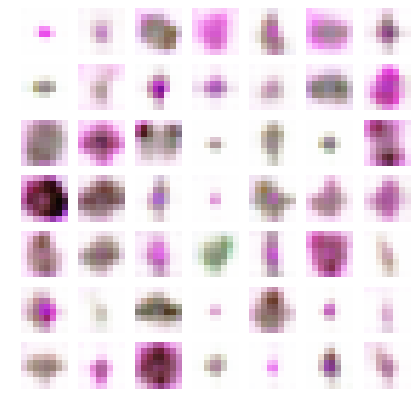

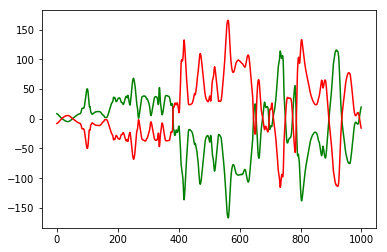

layer:8, epoch: 3500/5000, fader: 100.0%, vae_loss_var: 0.009999999776482582, sec: 3.75534
layer:8, epoch: 3501/5000, fader: 100.0%, vae_loss_var: 0.009999999776482582, sec: 0.27510
layer:8, epoch: 3502/5000, fader: 100.0%, vae_loss_var: 0.009999999776482582, sec: 0.27009
layer:8, epoch: 3503/5000, fader: 100.0%, vae_loss_var: 0.009999999776482582, sec: 0.26994
layer:8, epoch: 3504/5000, fader: 100.0%, vae_loss_var: 0.009999999776482582, sec: 0.27384
layer:8, epoch: 3505/5000, fader: 100.0%, vae_loss_var: 0.009999999776482582, sec: 0.27350
layer:8, epoch: 3506/5000, fader: 100.0%, vae_loss_var: 0.009999999776482582, sec: 0.27562
layer:8, epoch: 3507/5000, fader: 100.0%, vae_loss_var: 0.009999999776482582, sec: 0.27462
layer:8, epoch: 3508/5000, fader: 100.0%, vae_loss_var: 0.009999999776482582, sec: 0.27179
layer:8, epoch: 3509/5000, fader: 100.0%, vae_loss_var: 0.009999999776482582, sec: 0.27145
layer:8, epoch: 3510/5000, fader: 100.0%, vae_loss_var: 0.009999999776482582, sec: 0.27143

KeyboardInterrupt: ignored

In [0]:
EPOCHS = 5000
fade_in = EPOCHS/2
discriminate_loss_list = deque(maxlen=1000)
generate_loss_list = deque(maxlen=1000)

for i in range(checkpoint.stage.numpy(), 7):
    stage = 2**(i+2)
#     EPOCHS = int(15000*((i+2)/10))
#     fade_in = EPOCHS/2
    train_step = trainer()
    img_len = len(imgs)
    batchs = resize(imgs, stage)
    for epoch in range(checkpoint.epoch.numpy(), EPOCHS):
        gen_epoch_loss, disc_epoch_loss = [], []
        if epoch < fade_in:
            vae.fader.assign(epoch/fade_in)
            gen.fader.assign(epoch/fade_in)
            disc.fader.assign(epoch/fade_in)
        else:
            vae.fader.assign(1)
            gen.fader.assign(1)
            disc.fader.assign(1)
        start = time.time()
        for batch in batchs.shuffle(img_len).batch(128):
            gen_loss, disc_loss = train_step(batch)
            gen_epoch_loss.append(gen_loss)
            disc_epoch_loss.append(disc_loss)
        generate_loss_list.append(tf.reduce_mean(gen_epoch_loss))
        discriminate_loss_list.append(tf.reduce_mean(disc_epoch_loss))
        
        if epoch % 50 == 0:
            checkpoint.stage.assign(i)
            checkpoint.epoch.assign(epoch)
            checkpoint.save(file_prefix = checkpoint_prefix)
            generate_and_save_images(sigmoid(gen.model(seed, stage)), stage, epoch)
            plot_graph_disc_and_gan(discriminate_loss_list, generate_loss_list, stage)
            
        print ('layer:{}, epoch: {}/{}, fader: {:.1f}%, vae_loss_var: {}, sec: {:.5f}'.format(stage, epoch, EPOCHS, gen.fader*100, vae.vae_loss_var.numpy(), time.time()-start))
    checkpoint.stage.assign(i+1)
    checkpoint.epoch.assign(0)
    checkpoint.save(file_prefix = checkpoint_prefix)

In [0]:
for i in range(49):
#     test = tf.random.normal([1,noise_dim])
    seed_test = np.array([checkpoint.seed[i]])
    stage = 2**(checkpoint.stage.numpy()+2)
    predictions = gen.model(seed_test, stage)
#     test = tanh(predictions)/2 + 0.5
#     plt.imshow(test[0])
#     plt.show()
    test = sigmoid(predictions)
    plt.imshow(test[0])
    plt.show()
    

In [0]:
batches = resize(imgs, 4).shuffle(img_len).batch(128)

In [0]:
for x in batches:
    for i in x:
        plt.imshow(i)
        plt.show()
        break